# Running Simulations

## Introduction

This notebook demonstrates how to use the CT simulation tools included in the [pediatricIQphantoms](https://github.com/bnel1201/pediatricIQphantoms) repo and how these tools can be used to build pediatric IQ phantom datasets. These tools were used to generate the [pediatricIQphantoms dataset](https://zenodo.org/doi/10.5281/zenodo.10064035) using the [pediatricIQphantoms.toml](https://github.com/bnel1201/pediatricIQphantoms/blob/main/configs/pediatricIQphantoms.toml) configuration file.

This tutorial will introduce:
1. [individual simulations](#Individual-Simulations) - this section discusses key technique parameters and how to change them
2. [batch mode simulation](#Batch-Mode-Simulations) - this section introduces how to systematically iterate through parameters to build a dataset
3. [command line tool](#Command-Line-Interface-Tool:-make_phantoms) this section combines themes from the previous sections into a command line tool using configuration files consisting of the same technique parameters discussed in sections [individual simulations](#Individual-Simulations) and [batch mode simulation](#Batch-Mode-Simulations)

## Individual Simulations

The main tool for running individual simulations is the [CTobj class](https://pediatriciqphantoms.readthedocs.io/en/latest/api.html#pediatricIQphantoms.CTobj) which both holds the key parameters for running and describing the scan as well as having methods to [run the scan](https://pediatriciqphantoms.readthedocs.io/en/latest/api.html#pediatricIQphantoms.CTobj.run) and [write the output to dicom](https://pediatriciqphantoms.readthedocs.io/en/latest/api.html#pediatricIQphantoms.CTobj.write_to_dicom)

As shown in the Class signature above, most attributes have default values provided, these values correspond to a Siemen's Definition AS+ scanner as described in [Zeng et al 2022](https://aapm.onlinelibrary.wiley.com/doi/pdf/10.1002/mp.15430). Thus it can be defined and `run()` with no further initialization attributes. For this example we'll specify the CTP404 phantom and keep all other defaults.

In [1]:
from pediatricIQphantoms import CTobj
ct = CTobj('CTP404')
ct

<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm CTP404 I0: 300000.0

In [2]:
ct.run();

In [3]:
ct

<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm CTP404 I0: 300000.0
Recon: (1, 512, 512) 34.0 cm FOV
Projections: (900, 580)

You can access the reconstruction and projection data as numpy arrays via the object attributes:

In [4]:
type(ct.recon), ct.recon.shape, type(ct.projections), ct.projections.shape

(numpy.ndarray, (1, 512, 512), numpy.ndarray, (900, 580))

In [5]:
fname = ct.write_to_dicom('test.dcm')

import pydicom
dcm = pydicom.read_file(fname[0])
dcm.PatientName

'20.0 cm CTP404'

In [6]:
!pip install ipywidgets -q

In [7]:
import matplotlib.pyplot as plt

from utils import ctshow

The [`CTobj`](https://pediatriciqphantoms.readthedocs.io/en/latest/api.html#pediatricIQphantoms.CTobj) ooject also holds the `groundtruth` attribute following the reconstruction

Text(0.5, 1.0, 'Ground Truth')

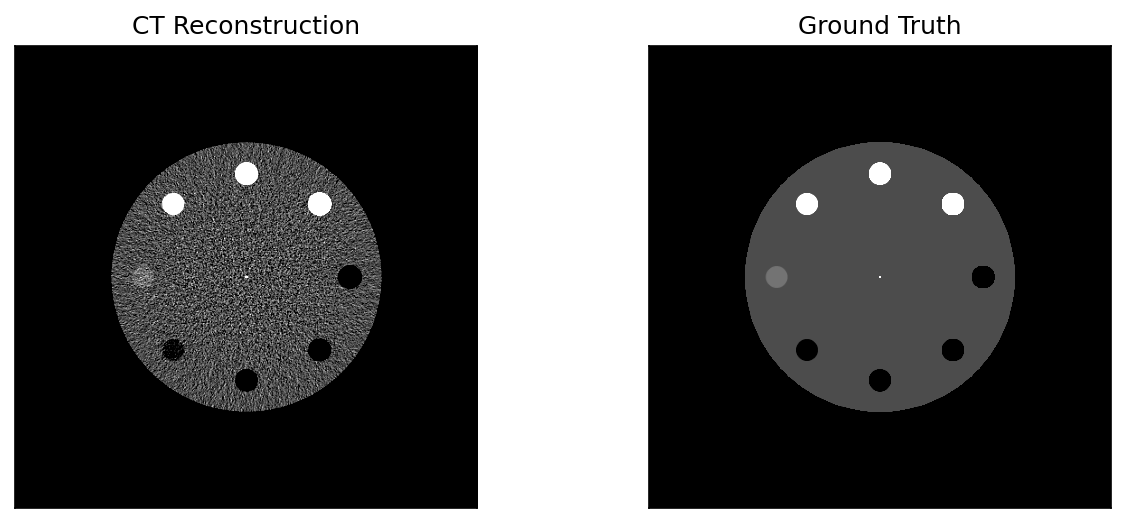

In [8]:
plt.figure(figsize=(10,4), dpi=150)
plt.subplot(1,2,1)
win, lvl = 100, 20
display_settings = (win, lvl)
ctshow(ct.recon[0], display_settings)
plt.title('CT Reconstruction')
plt.subplot(1,2,2)
ctshow(ct.groundtruth, display_settings)
plt.title('Ground Truth')

The `CTobj` ooject also holds the `projections`

Text(0, 0.5, 'detector index')

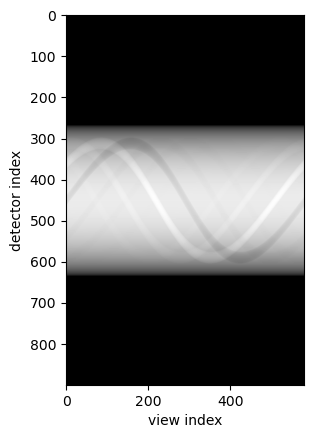

In [9]:
import numpy as np
plt.imshow(-np.log(ct.projections), cmap='gray')
plt.xlabel('view index')
plt.ylabel('detector index')

### Different Phantoms

Here we demonstrate the different phantoms available by defining three CTobj objects each with different phantoms

In [10]:
ctp404 = CTobj('CTP404').run();
mital_lcd = CTobj('MITA-LCD', I0=3e7).run()# <-- higher dose to show low contrast lesions
uniform = CTobj('uniform').run();

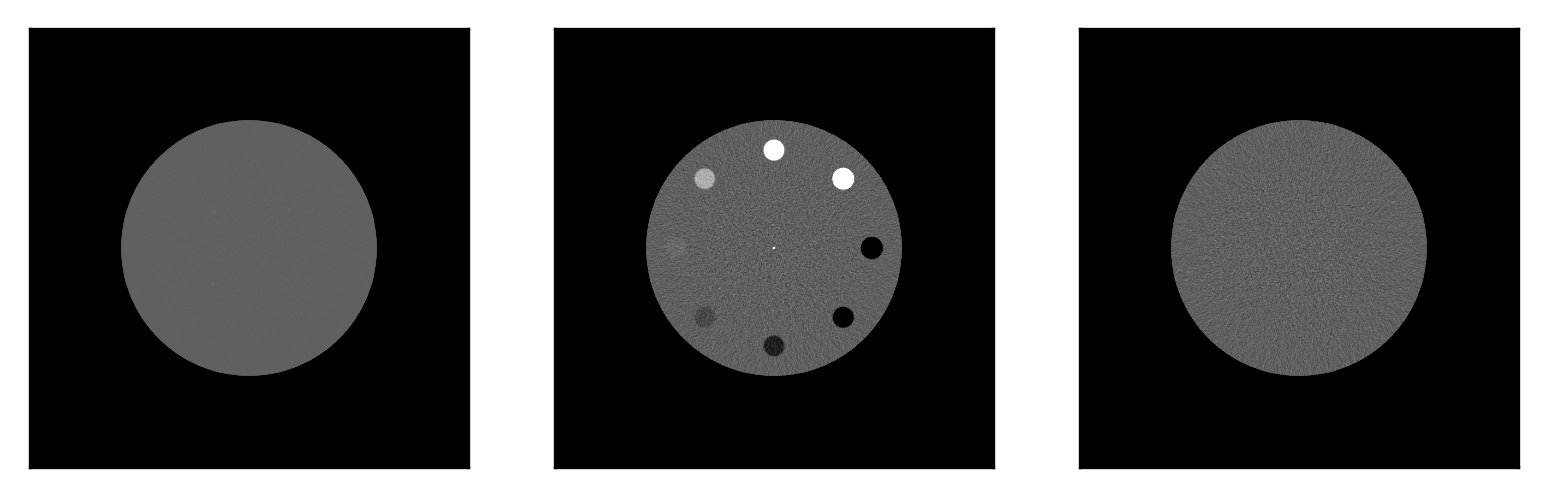

In [11]:
plt.figure(dpi=300)

display_settings =  'soft tissues'

plt.subplot(1,3,1)
ctshow(mital_lcd.recon, display_settings)

plt.subplot(1,3,2)
ctshow(ctp404.recon)

plt.subplot(1,3,3)
ctshow(uniform.recon, display_settings)
plt.show()

### Different Dose Levels

Next let's run a simulation using the `Uniform` phantom but scanned at different dose levels to see how noise trends compare with increasing dose level

In [ ]:
import numpy as np
doses = np.linspace(1e5, 8e5, 50)
res_list = [CTobj('Uniform', I0=I0, nsims=2).run() for I0 in doses]

In [ ]:
res_list

In [ ]:
nres = 3
std_noise = []
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    nz, nx, ny = res.recon.shape
    if idx//3 == 0:
        plt.subplot(1, nres, idx+1)
        ctshow(res.recon[0, nx//2-nx//8:nx//2+nx//8, nx//2-nx//8:nx//2+nx//8], 'soft tissues')
    nz, nx, ny = res.recon.shape
    std_noise.append(res.recon[0, nx//2-nx//8:nx//2+nx//8, nx//2-nx//8:nx//2+nx//8].std())
    plt.title(f'Photons/pixel {doses[idx]:1.1g}\nstd: {std_noise[idx]:2.2f} HU')

In [ ]:
rel_doses = doses/doses.max()*100
plt.plot(rel_doses, std_noise)
plt.ylabel('Noise Std [HU]')
plt.xlabel('Dose Level [%]')

In [ ]:
from pathlib import Path
writedir=Path('data/test')
fnames=[]
for res in res_list:
    fname = res.write_to_dicom(writedir / f'{res.seriesname}.dcm')
    fnames += fname
len(fnames)

### Recon Type

In MIRT convolution kernels are specified as `<window function>,<cutoff frequency mm>` for example a typical sharp kernel can be defined as 'hanning,2.05' where a [Hann window](https://en.wikipedia.org/wiki/Hann_function) with a cuffoff ([MTF](https://www.sciencedirect.com/topics/physics-and-astronomy/modulation-transfer-function#:~:text=The%20modulation%20transfer%20function%20(MTF,gets%20transferred%20to%20the%20image.)=0) frequency of 2.05 mm. The table below provides a few Siemen's equivalent kernels based upon matching 50% and 10% MTF cutoffs ([Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430)).

| Description | MIRT         | Siemen's Equivalent |
|:-----------:|--------------|---------------------|
| Sharp       | hanning,2.05 | D45                 |
| Smooth      | hanning,0.85 | B30               

The following experiment runs simulations on increasingly higher cutoff frequency kernels ranging from smooth to sharp.  |

In [ ]:
cutoff_freq = [0.5, 0.85, 2.05]

res_list = [CTobj('MITA-LCD', I0=1e6, fbp_kernel=f'hanning,{freq:1.2f}').run() for freq in cutoff_freq]    

In [ ]:
nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, (40, 0))
    plt.title(f'Kernel cutoff {cutoff_freq[idx]}')

### Phantom Size and FOV

Finally let's see how noise texture changes as a result of imaging different sized phantoms with body fitting field of views (FOV)s.

In [ ]:
phantom_diameters = [112, 185, 292]

res_list = [CTobj('MITA-LCD', I0=1e6, patient_diameter=d).run() for d in phantom_diameters]   

In [ ]:
fov = np.array(phantom_diameters)*1.1 # in mm
dx = fov/res.recon.shape[-1]

nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, 'liver')
    plt.title(f'Phantom Diameter {phantom_diameters[idx]} [mm]\n(FOV: {fov[idx]:2.0f} mm, voxel size: {dx[idx]:2.2f} mm)', fontsize=8)

By default when FOV is not specified, it defaults to a body fitting 1.1x the phantom diameter. Note how FOV changes the relative pixel size

## Batch Mode Simulations

The following introduces how to interactively construct batch simulations in a python environment using [run_batch_sim](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L178)

In [ ]:
from pediatricIQphantoms import run_batch_sim

Batch mode can be run by either entering in parameter lists for `model`, `diameter`, or `dose_level`

In [ ]:
metadata = run_batch_sim(image_directory='data/interactive_batch', dose_level=[0.1, 0.25, 0.5, 1]);

In [ ]:
metadata.head()

Alternatively, you can load in a config file and change it as needed and then input to `run_batch_sim` using the [`**` operator](https://realpython.com/python-kwargs-and-args/)

In [ ]:
import tomli
with open('sample_config_file.toml', 'rb') as f:
    config_file = tomli.load(f)
config_file

In [ ]:
config_file.keys(), len(config_file['simulation'])

Note: the toml config files are structured to allow multiple simulations with updating select parameters in each simulation, see [Documentation/Usage](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html) for more details.

This for this example, we want to take the first simulation since `run_batch_sim` expects only flat dictionaries, str, float, and int arguments.

In [ ]:
config = config_file['simulation'][0]
config

In [ ]:
config['image_directory'] = 'data/interactive_batch'
config['dose_level'] = [0.1, 0.25, 0.5, 1]
metadata = run_batch_sim(**config)
metadata.head()

## Command Line Interface Tool: `make_phantoms`

Finally, datasets can be made in batch mode using the command line tool [`make_phantoms`](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L224) that should be available globally in your terminal after pip [installing](https://github.com/bnel1201/pediatricIQphantoms?tab=readme-ov-file#start-here) the `pediatricIQphantoms` package.

In [ ]:
!make_phantoms -help

For this example we will use [test.toml](../tests/configs/test.toml) as quick example

In [ ]:
!cat sample_config_file.toml

In [ ]:
!make_phantoms sample_config_file.toml

## Conclusions

In this notebook we walked through how to run [individual simulations](#Individual-Simulations) and [batched simulations](#Batch-Mode-Simulations) interactively as well as how to run and modify configuration files to be run noninteractively using the command line interface.

**Next** see the notebook on [viewing the simulation images](01_viewing_images.ipynb)